<a href="https://colab.research.google.com/github/dragoa/MachineLearning/blob/main/DL/02_Introduction_to_self_supervised_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to self-supervised learning with basic methods

In [2]:
import numpy as np
import math
from tensorflow import keras
import random
import matplotlib.pyplot as plt
from keras.applications.densenet import DenseNet121
from keras.applications.densenet import preprocess_input
from keras.layers import GlobalAveragePooling2D,Dense
from keras.models import Model
import tensorflow as tf

In this lab, we will understand better the working principles and the benefits of self-supervised learning.
As an example, we will utilize the dataset CIFAR10, which is available in *keras datasets*.


In [3]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

#dictionary for the classes

classes = {0 :"airplane",
1	:"automobile",
2	:"bird",
3	:"cat",
4	:"deer",
5	:"dog",
6	:"frog",
7	:"horse",
8	:"ship",
9	:"truck"}

170498071/170498071 [==============================] - 6s 0us/step


Let us visualize ten random samples from CIFAR10

In [4]:
print(x_train.shape)
print(type(x_train))
print(y_train.shape)
print(y_train[0])

(50000, 32, 32, 3)
<class 'numpy.ndarray'>
(50000, 1)
[6]


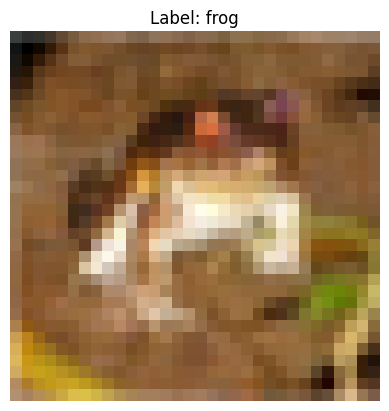

In [5]:
first_image = x_train[0]
first_label = str(y_train[0]).strip("[]")

# Visualize the first image
plt.imshow(first_image)
plt.title("Label: " + classes[int(first_label)])
plt.axis('off')
plt.show()

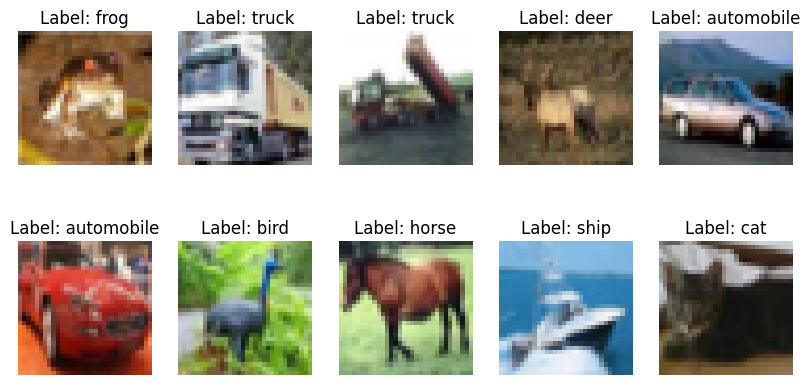

In [6]:
# pick ten random training images (using the library random) and visualize them in a grid with matplotlib
samples = random.sample(range(len(x_train)), 10)

plt.figure(figsize=(10, 5))
for i, index in enumerate(samples):
  img = x_train[i]
  label = str(y_train[i]).strip("[]")

  # Visualize the first image
  plt.subplot(2, 5, i + 1)
  plt.imshow(img)
  plt.title("Label: " + classes[int(label)])
  plt.axis('off')
plt.show()

Now, we will initiliaze a model based on DenseNet121 (from scratch), a good trade-off between efficiency and efficacy.
We will use the library keras applications.

In [7]:
def initialize_model(num_classes):

    #initiliaze a backbone of DenseNet121 (without the top layers for classification).
    #fill with keras application DenseNet121, remember to exclude the top
    base_model = DenseNet121(include_top=False)

    x = base_model.output
    print(x)

    #now, we will build the model for CIFAR10 classification
    # let's add a Global average pooling
    x = GlobalAveragePooling2D()(x)

    # Add a fully-connected layer with 512 neurons (relu activation)
    x = Dense(512, activation='relu')(x)
    # Add the output layer
    predictions = Dense(num_classes, activation='softmax')(x)
    # Define the full model
    model = Model(inputs=base_model.input, outputs=predictions)
    # Compile the model with optimizer and loss function (categorical cross-entropy)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model

Now, create the three subsets with cardinality c1 = 2000, c2= 5000, c3 = 10000.

**tip**: we want a balanced dataset, so use stratified train test split from sklearn library (the idea will be to create a split with

${test\_size}_i = (1 - \frac{c\_i}{\vert x\_train \vert}, i=1,2,3$)

discarding the test split

In [8]:
from sklearn.model_selection import train_test_split

# Create subsets with cardinality c1 = 2000, c2 = 5000, c3 = 10000
cardinalities = [2000, 5000, 10000]

# Initialize lists to store the subsets
x_train_subsets = []
y_train_subsets = []

# Stratified train test split for each cardinality
for c in cardinalities:
    x_train_subset, _, y_train_subset, _ = train_test_split(x_train, y_train, test_size=1 - c/len(x_train), stratify=y_train)
    x_train_subsets.append(x_train_subset)
    y_train_subsets.append(y_train_subset)

# Initialize and train models for each subset
num_classes = 10  # Number of classes in CIFAR-10 dataset

In [9]:
from keras.utils import to_categorical

model_c = []

for i,c in enumerate(cardinalities):

    # Initialize the model
    model_c_i = initialize_model(num_classes)

    # Normalize the x_train_subset
    x_train_subset = x_train_subsets[i].astype('float32') / 255.0

    # Convert the y_train_subset to one-hot encoding
    y_train_subset = to_categorical(y_train_subsets[i], num_classes)

    # Fit the model
    model_c_i.fit(x_train_subset, y_train_subset, epochs=10, batch_size=32)
    model_c.append(model_c_i)

29084464/29084464 [==============================] - 1s 0us/step
KerasTensor(type_spec=TensorSpec(shape=(None, None, None, 1024), dtype=tf.float32, name=None), name='relu/Relu:0', description="created by layer 'relu'")
Epoch 1/10
63/63 [==============================] - 75s 134ms/step - loss: 2.0160 - accuracy: 0.3430
Epoch 2/10
63/63 [==============================] - 6s 87ms/step - loss: 1.3817 - accuracy: 0.5290
Epoch 3/10
63/63 [==============================] - 5s 75ms/step - loss: 1.2680 - accuracy: 0.5730
Epoch 4/10
63/63 [==============================] - 6s 97ms/step - loss: 1.0023 - accuracy: 0.6650
Epoch 5/10
63/63 [==============================] - 5s 75ms/step - loss: 0.8761 - accuracy: 0.7075
Epoch 6/10
63/63 [==============================] - 5s 86ms/step - loss: 0.6843 - accuracy: 0.7695
Epoch 7/10
63/63 [==============================] - 5s 75ms/step - loss: 0.4744 - accuracy: 0.8465
Epoch 8/10
63/63 [==============================] - 5s 73ms/step - loss: 0.5622 - accu

evaluate the model on the whole **original** test set



In [10]:
scratch_accuracies = []
# Normalize the original test set
x_test = x_test.astype('float32') / 255.0

for i,c in enumerate(cardinalities):

  # Evaluate model_c on the original test set
  scratch_loss, scratch_accuracy = model_c[i].evaluate(x_test, to_categorical(y_test, num_classes))
  print("scratch_loss - Test Loss:", scratch_loss)
  print("scratch_accuracy - Test Accuracy:", scratch_accuracy)
  scratch_accuracies.append(scratch_accuracy)

313/313 [==============================] - 6s 13ms/step - loss: 1.5942 - accuracy: 0.5845
scratch_loss - Test Loss: 1.5941733121871948
scratch_accuracy - Test Accuracy: 0.5845000147819519
313/313 [==============================] - 7s 15ms/step - loss: 1.6729 - accuracy: 0.5071
scratch_loss - Test Loss: 1.6728845834732056
scratch_accuracy - Test Accuracy: 0.507099986076355
313/313 [==============================] - 6s 13ms/step - loss: 1.2903 - accuracy: 0.6425
scratch_loss - Test Loss: 1.2903366088867188
scratch_accuracy - Test Accuracy: 0.6424999833106995


Now, we will implement a rotation self-supervised pre-text task.
So:



*   Create the pre-text dataset
*   Initialize a model
*   train the model from scratch on the pre-text task



**Crate the pre-text dataset**

input: a training set with no labels (x_train,), rotation_set = [0,1,2,3]

create a copy of the original dataset (x_train_rotated)

create an empty vector of labels (y_train_rotated)

```
For i in range(0,len(x_train)):

    k = pick a random element of rotation set

    x_train_rotated[i] = rotate(x[i], k)   #look for an appropriate function in tf.image

    y_train_rotated[i] = k

```

In [11]:
# Function to rotate images
def rotate_image(image, rotation):
    return tf.image.rot90(image, rotation)

In [12]:
# Create a copy of the original dataset
x_train_rotated = np.copy(x_train)
y_train_rotated = np.zeros(len(x_train), dtype=np.int32)

# Rotation set
rotation_set = [0, 1, 2, 3]

# Generate random rotations
for i in range(len(y_train_rotated)):
    # Pick a random rotation
    rot = np.random.choice(rotation_set)

    # Apply rotation to the image
    x_train_rotated[i] = rotate_image(x_train_rotated[i], rot)

    # Store the rotation label
    y_train_rotated[i] = rot

Visualize ten random samples to verify the obtained dataset

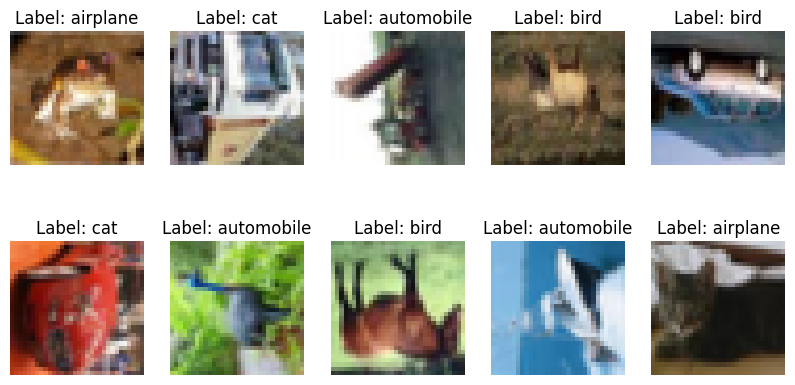

In [13]:
# pick ten random training images (using the library random) and visualize them in a grid with matplotlib
samples = random.sample(range(len(x_train_rotated)), 10)

plt.figure(figsize=(10, 5))
for i, index in enumerate(samples):
  img = x_train_rotated[i]
  label = str(y_train_rotated[i]).strip("[]")

  # Visualize the first image
  plt.subplot(2, 5, i + 1)
  plt.imshow(img)
  plt.title("Label: " + classes[int(label)])
  plt.axis('off')
plt.show()

Re-define a DenseNet121 model, as done before (**careful on the output layer**).

In [14]:
model = initialize_model(num_classes)

KerasTensor(type_spec=TensorSpec(shape=(None, None, None, 1024), dtype=tf.float32, name=None), name='relu/Relu:0', description="created by layer 'relu'")


fit the model for the pre-text task

In [15]:
from keras.utils import to_categorical

#normalize the x_train_subset
x_train_subset = x_train_subsets[0].astype('float32') / 255.0
#convert the y_train_subset in one-hot encoding (use to_categorical in keras)
y_train_subset = to_categorical(y_train_subsets[0], num_classes)
#fit the model
model.fit(x_train_subset, y_train_subset, epochs=10, batch_size=32)
#use model.save_weights(checkpoints/model_name) to store the learned weights
model.save_weights('checkpoints/DenseNet121_1')

Epoch 1/10
63/63 [==============================] - 57s 76ms/step - loss: 2.0359 - accuracy: 0.3250
Epoch 2/10
63/63 [==============================] - 5s 73ms/step - loss: 1.5013 - accuracy: 0.5115
Epoch 3/10
63/63 [==============================] - 5s 87ms/step - loss: 1.1509 - accuracy: 0.6040
Epoch 4/10
63/63 [==============================] - 5s 73ms/step - loss: 1.0416 - accuracy: 0.6535
Epoch 5/10
63/63 [==============================] - 5s 85ms/step - loss: 0.8979 - accuracy: 0.6960
Epoch 6/10
63/63 [==============================] - 5s 75ms/step - loss: 0.7176 - accuracy: 0.7510
Epoch 7/10
63/63 [==============================] - 5s 72ms/step - loss: 0.6558 - accuracy: 0.7775
Epoch 8/10
63/63 [==============================] - 5s 86ms/step - loss: 0.5981 - accuracy: 0.8085
Epoch 9/10
63/63 [==============================] - 5s 72ms/step - loss: 0.4771 - accuracy: 0.8430
Epoch 10/10
63/63 [==============================] - 5s 85ms/step - loss: 0.3512 - accuracy: 0.8930


fine-tune the model on the downstream task.

To do so:



*   Take the trained backbone of the pre-text task
*   Re-define the classification hat (with the appropriate output layer)
*   Re-train (use a lower learning rate than training from scratch)



In [16]:
from keras.optimizers import Adam

model_rot = []
# Define the learning rate for fine-tuning
learning_rate = 0.0001  # Adjust as needed

for i, c in enumerate(cardinalities):
    # Initialize model
    model_rot = initialize_model(num_classes)

    # Load the weights previously stored
    model_rot.load_weights('checkpoints/DenseNet121_1').expect_partial()

    # Retrieve the backbone's output
    backbone_output = model_rot.layers[-4].output

    # Re-add global average pooling
    x = GlobalAveragePooling2D()(backbone_output)

    # Add a fully-connected layer with 512 neurons (relu activation)
    x = Dense(512, activation='relu')(x)

    # Add the output layer
    predictions = Dense(num_classes, activation='softmax')(x)

    # Set the backbone layers to be trainable
    for layer in model_rot.layers[:-4]:
        layer.trainable = True

    # Compile the model with a lower learning rate for fine-tuning
    model_rot.compile(optimizer=Adam(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])

    # Normalize the x_train_subset
    x_train_subset = x_train_subsets[i].astype('float32') / 255.0

    # Convert the y_train_subset to one-hot encoding
    y_train_subset = to_categorical(y_train_subsets[i], num_classes)

    # Train the model on the subset
    model_rot.fit(x_train_subset, y_train_subset, epochs=10, batch_size=32)

KerasTensor(type_spec=TensorSpec(shape=(None, None, None, 1024), dtype=tf.float32, name=None), name='relu/Relu:0', description="created by layer 'relu'")
Epoch 1/10
63/63 [==============================] - 57s 85ms/step - loss: 0.1094 - accuracy: 0.9610
Epoch 2/10
63/63 [==============================] - 5s 74ms/step - loss: 0.0599 - accuracy: 0.9845
Epoch 3/10
63/63 [==============================] - 5s 87ms/step - loss: 0.0461 - accuracy: 0.9865
Epoch 4/10
63/63 [==============================] - 5s 76ms/step - loss: 0.0450 - accuracy: 0.9850
Epoch 5/10
63/63 [==============================] - 5s 82ms/step - loss: 0.0189 - accuracy: 0.9935
Epoch 6/10
63/63 [==============================] - 5s 78ms/step - loss: 0.0239 - accuracy: 0.9935
Epoch 7/10
63/63 [==============================] - 5s 73ms/step - loss: 0.0156 - accuracy: 0.9960
Epoch 8/10
63/63 [==============================] - 5s 86ms/step - loss: 0.0139 - accuracy: 0.9980
Epoch 9/10
63/63 [==============================] - 5

In [24]:
SSL_accuracies = []
# Normalize the original test set
x_test = x_test.astype('float32') / 255.0

for i, c in enumerate(cardinalities):
    # Evaluate model_rot on the original test set
    SSL_loss, SSL_accuracy = model_rot.evaluate(x_test, to_categorical(y_test, num_classes))
    print(f"SSL_loss - Test Loss (Cardinality {c}):", SSL_loss)
    print(f"SSL_accuracy - Test Accuracy (Cardinality {c}):", SSL_accuracy)
    SSL_accuracies.append(SSL_accuracy)


313/313 [==============================] - 4s 13ms/step - loss: 7.3011 - accuracy: 0.1000
SSL_loss - Test Loss (Cardinality 2000): 7.301095485687256
SSL_accuracy - Test Accuracy (Cardinality 2000): 0.10000000149011612
313/313 [==============================] - 5s 15ms/step - loss: 7.3011 - accuracy: 0.1000
SSL_loss - Test Loss (Cardinality 5000): 7.301095485687256
SSL_accuracy - Test Accuracy (Cardinality 5000): 0.10000000149011612
313/313 [==============================] - 4s 12ms/step - loss: 7.3011 - accuracy: 0.1000
SSL_loss - Test Loss (Cardinality 10000): 7.301095485687256
SSL_accuracy - Test Accuracy (Cardinality 10000): 0.10000000149011612


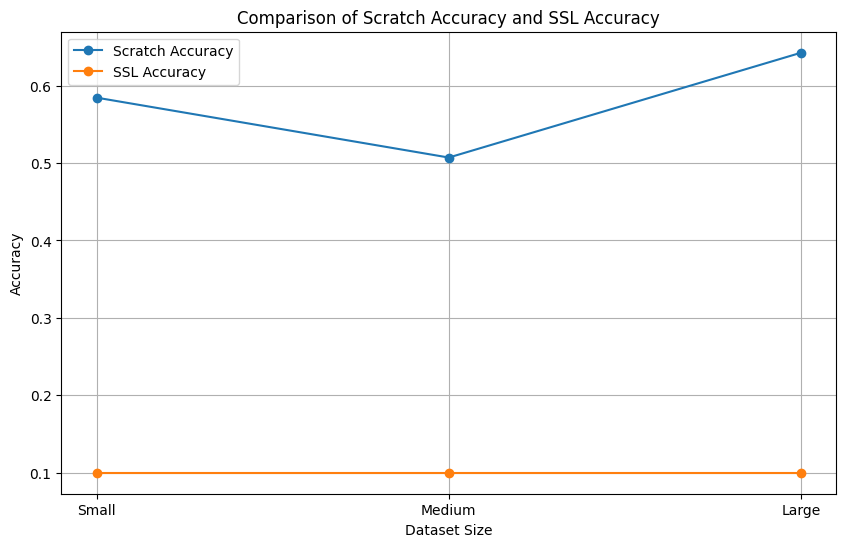

In [25]:
import matplotlib.pyplot as plt

# Assuming you have collected scratch_accuracies and SSL_accuracies for the three different sizes

# Sizes of the datasets
sizes = ['Small', 'Medium', 'Large']

# Plotting
plt.figure(figsize=(10, 6))

plt.plot(sizes, scratch_accuracies, marker='o', label='Scratch Accuracy')
plt.plot(sizes, SSL_accuracies, marker='o', label='SSL Accuracy')

plt.title('Comparison of Scratch Accuracy and SSL Accuracy')
plt.xlabel('Dataset Size')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()
